### Environment Setup

#### Colab Specifics

In [3]:
%cd /content/
%pwd
!git clone https://github.com/sramshetty/Balanced-Contrastive-Learning.git
%cd Balanced-Contrastive-Learning/

/content
fatal: destination path 'Balanced-Contrastive-Learning' already exists and is not an empty directory.
/content/Balanced-Contrastive-Learning


In [4]:
!git pull

Already up to date.


In [5]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#### General Setup

In [24]:
import torch
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np

from tqdm import tqdm
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
import matplotlib.pyplot as plt

# from dataset.cifar import IMBALANCECIFAR10, IMBALANCECIFAR100

In [7]:
%load_ext autoreload
%autoreload 2

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
!pip install vit-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load Data

CIFAR-10-LT

In [8]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [13]:
cifar10_trainDataset = IMBALANCECIFAR10(root='/DATACENTER/3/zjg/cifar', train=True,
                                 download=True, transform=transform)
cifar10_testDataset = IMBALANCECIFAR10(root='/DATACENTER/3/zjg/cifar', train=False,
                                 download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /DATACENTER/3/zjg/cifar/cifar-10-python.tar.gz to /DATACENTER/3/zjg/cifar
Files already downloaded and verified


In [ ]:
# Data size
print(len(cifar10_trainDataset.data))
print(len(cifar10_testDataset.data))
print(cifar10_trainDataset.get_cls_num_list())

12406
2478
[5000, 2997, 1796, 1077, 645, 387, 232, 139, 83, 50]


In [ ]:
cifar10_train_loader = DataLoader(cifar10_trainDataset, batch_size=64, shuffle=True, pin_memory=True)
cifar10_test_loader = DataLoader(cifar10_testDataset, batch_size=64, shuffle=False, pin_memory=True)

CIFAR-100-LT

In [9]:
cifar100_trainDataset = IMBALANCECIFAR100(root='/DATACENTER/3/zjg/cifar', train=True,
                                 download=True, transform=transform)
cifar100_testDataset = IMBALANCECIFAR100(root='/DATACENTER/3/zjg/cifar', train=False,
                                 download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Data size
print(len(cifar100_trainDataset.data))
print(len(cifar100_testDataset.data))
print(cifar100_trainDataset.get_cls_num_list())

10847
2131
[500, 477, 455, 434, 415, 396, 378, 361, 344, 328, 314, 299, 286, 273, 260, 248, 237, 226, 216, 206, 197, 188, 179, 171, 163, 156, 149, 142, 135, 129, 123, 118, 112, 107, 102, 98, 93, 89, 85, 81, 77, 74, 70, 67, 64, 61, 58, 56, 53, 51, 48, 46, 44, 42, 40, 38, 36, 35, 33, 32, 30, 29, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 15, 14, 13, 13, 12, 12, 11, 11, 10, 10, 9, 9, 8, 8, 7, 7, 7, 6, 6, 6, 6, 5, 5, 5, 5]


In [ ]:
cifar100_train_loader = DataLoader(cifar100_trainDataset, batch_size=64, shuffle=True, pin_memory=True)
cifar100_test_loader = DataLoader(cifar100_testDataset, batch_size=64, shuffle=False, pin_memory=True)

## Supervised Results

In [ ]:
def basic_train(model, train_loader, optimizer, criterion, n_epochs=100):
    model.to(device)
    model.train()

    accs = []
    losses = []

    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_correct = 0
        num_preds = 0

        print(f"Epoch {epoch}")
        for data, targets in tqdm(train_loader):
            optimizer.zero_grad()

            data = data.to(device)
            targets = targets.to(device)
            batch_size = targets.size()[0]

            logits = model(data)

            loss = criterion(logits, targets)
            epoch_loss += loss.item()
            loss.backward()

            epoch_correct += torch.sum(torch.argmax(logits, dim=1) == targets).item()
            num_preds += batch_size

            optimizer.step()
        
        epoch_acc = epoch_correct / num_preds
        accs.append(epoch_acc)
        losses.append(epoch_loss)

        print(f"Loss = {epoch_loss}")
        print(f"Accuracy = {epoch_acc}")

    model.cpu()
    return accs, losses

def basic_test(model, test_loader, criterion):
    model.to(device)
    model.eval()

    preds = []
    labels = []

    with torch.no_grad():
        epoch_loss = 0
        for data, targets in tqdm(test_loader):
            data = data.to(device)
            targets =targets.to(device)

            logits = model(data)

            loss = criterion(logits, targets)
            epoch_loss += loss.item()

            preds += torch.argmax(logits, dim=1).view(-1).cpu().detach().tolist()
            labels += targets.cpu().detach().tolist()

        print("Test Loss = ", epoch_loss)

    model.cpu()
    return preds, labels

In [ ]:
criterion = nn.CrossEntropyLoss()

### CIFAR-10-LT



#### ResNet Models

In [ ]:
from torchvision.models import resnet34, ResNet34_Weights

ResNet-34 Trained from Scratch

In [ ]:
res34_model = resnet34(weights=None, num_classes=10)
res34_opt = torch.optim.Adam(res34_model.parameters(), lr=0.03)

res34_accs, res34_losses = basic_train(res34_model, cifar10_train_loader, res34_opt, criterion, n_epochs=50)
print("-"*20)
print("Best Accuracy =", max(res34_accs))

Epoch 0


100%|██████████| 194/194 [00:23<00:00,  8.30it/s]


Loss = 382.2285565137863
Accuracy = 0.4365629534096405
Epoch 1


100%|██████████| 194/194 [00:16<00:00, 11.82it/s]


Loss = 259.66091310977936
Accuracy = 0.5311945832661615
Epoch 2


100%|██████████| 194/194 [00:15<00:00, 12.52it/s]


Loss = 216.23099905252457
Accuracy = 0.6178462034499436
Epoch 3


100%|██████████| 194/194 [00:16<00:00, 12.01it/s]


Loss = 198.086345911026
Accuracy = 0.6520232145735935
Epoch 4


100%|██████████| 194/194 [00:16<00:00, 11.62it/s]


Loss = 182.32195591926575
Accuracy = 0.6849105271642754
Epoch 5


100%|██████████| 194/194 [00:16<00:00, 11.66it/s]


Loss = 175.17911046743393
Accuracy = 0.6978075124939546
Epoch 6


100%|██████████| 194/194 [00:15<00:00, 12.30it/s]


Loss = 164.75151526927948
Accuracy = 0.714331774947606
Epoch 7


100%|██████████| 194/194 [00:15<00:00, 12.54it/s]


Loss = 156.8748990893364
Accuracy = 0.7281154280187007
Epoch 8


100%|██████████| 194/194 [00:16<00:00, 11.92it/s]


Loss = 156.2521566748619
Accuracy = 0.7274705787522167
Epoch 9


100%|██████████| 194/194 [00:15<00:00, 12.26it/s]


Loss = 146.02886629104614
Accuracy = 0.7472996936965984
Epoch 10


100%|██████████| 194/194 [00:15<00:00, 12.36it/s]


Loss = 133.5399297773838
Accuracy = 0.7678542640657746
Epoch 11


100%|██████████| 194/194 [00:15<00:00, 12.31it/s]


Loss = 126.73347270488739
Accuracy = 0.7810736740286958
Epoch 12


100%|██████████| 194/194 [00:16<00:00, 11.98it/s]


Loss = 120.52386635541916
Accuracy = 0.7896985329679187
Epoch 13


100%|██████████| 194/194 [00:15<00:00, 12.35it/s]


Loss = 109.7722595334053
Accuracy = 0.80944704175399
Epoch 14


100%|██████████| 194/194 [00:15<00:00, 12.58it/s]


Loss = 107.64649617671967
Accuracy = 0.8160567467354506
Epoch 15


100%|██████████| 194/194 [00:15<00:00, 12.38it/s]


Loss = 95.40137612819672
Accuracy = 0.8317749476059971
Epoch 16


100%|██████████| 194/194 [00:16<00:00, 11.97it/s]


Loss = 87.2627542167902
Accuracy = 0.8431404159277769
Epoch 17


100%|██████████| 194/194 [00:15<00:00, 12.44it/s]


Loss = 78.08941592276096
Accuracy = 0.8595034660648073
Epoch 18


100%|██████████| 194/194 [00:16<00:00, 12.08it/s]


Loss = 72.87595757842064
Accuracy = 0.8711107528615186
Epoch 19


100%|██████████| 194/194 [00:16<00:00, 12.02it/s]


Loss = 61.30721037834883
Accuracy = 0.8919071417056263
Epoch 20


100%|██████████| 194/194 [00:15<00:00, 12.31it/s]


Loss = 56.26574546843767
Accuracy = 0.9031113977107851
Epoch 21


100%|██████████| 194/194 [00:15<00:00, 12.37it/s]


Loss = 49.832262106239796
Accuracy = 0.9147186845074964
Epoch 22


100%|██████████| 194/194 [00:15<00:00, 12.46it/s]


Loss = 42.35718277096748
Accuracy = 0.9256005158794132
Epoch 23


100%|██████████| 194/194 [00:16<00:00, 11.85it/s]


Loss = 40.45154129713774
Accuracy = 0.9290665806867645
Epoch 24


100%|██████████| 194/194 [00:15<00:00, 12.63it/s]


Loss = 35.32641898095608
Accuracy = 0.9347090117684991
Epoch 25


100%|██████████| 194/194 [00:15<00:00, 12.52it/s]


Loss = 34.01425019837916
Accuracy = 0.9402708366919232
Epoch 26


100%|██████████| 194/194 [00:15<00:00, 12.32it/s]


Loss = 29.47924720775336
Accuracy = 0.9500241818474932
Epoch 27


100%|██████████| 194/194 [00:16<00:00, 11.94it/s]


Loss = 28.15159012749791
Accuracy = 0.9497823633725616
Epoch 28


100%|██████████| 194/194 [00:15<00:00, 12.45it/s]


Loss = 26.275651393458247
Accuracy = 0.9558278252458488
Epoch 29


100%|██████████| 194/194 [00:15<00:00, 12.23it/s]


Loss = 26.76768250297755
Accuracy = 0.9548605513461228
Epoch 30


100%|██████████| 194/194 [00:15<00:00, 12.45it/s]


Loss = 24.555289255455136
Accuracy = 0.9569563114621957
Epoch 31


100%|██████████| 194/194 [00:16<00:00, 11.90it/s]


Loss = 16.62390642380342
Accuracy = 0.9725939061744318
Epoch 32


100%|██████████| 194/194 [00:15<00:00, 12.31it/s]


Loss = 19.047134451102465
Accuracy = 0.968241173625665
Epoch 33


100%|██████████| 194/194 [00:16<00:00, 12.03it/s]


Loss = 17.11046067578718
Accuracy = 0.9699339029501854
Epoch 34


100%|██████████| 194/194 [00:15<00:00, 12.40it/s]


Loss = 21.848913388326764
Accuracy = 0.9630017733354829
Epoch 35


100%|██████████| 194/194 [00:16<00:00, 11.96it/s]


Loss = 15.452495687175542
Accuracy = 0.9724326938578107
Epoch 36


100%|██████████| 194/194 [00:15<00:00, 12.34it/s]


Loss = 15.953950406517833
Accuracy = 0.9719490569079478
Epoch 37


100%|██████████| 194/194 [00:15<00:00, 12.47it/s]


Loss = 13.736520430189557
Accuracy = 0.9763017894567145
Epoch 38


100%|██████████| 194/194 [00:15<00:00, 12.35it/s]


Loss = 142.94086777279153
Accuracy = 0.8655489279380945
Epoch 39


100%|██████████| 194/194 [00:16<00:00, 11.96it/s]


Loss = 196.96163514256477
Accuracy = 0.6655650491697566
Epoch 40


100%|██████████| 194/194 [00:15<00:00, 12.34it/s]


Loss = 132.49536848068237
Accuracy = 0.769708205706916
Epoch 41


100%|██████████| 194/194 [00:15<00:00, 12.48it/s]


Loss = 84.39987699687481
Accuracy = 0.8548283088827986
Epoch 42


100%|██████████| 194/194 [00:16<00:00, 11.94it/s]


Loss = 49.55623613297939
Accuracy = 0.9176205062066742
Epoch 43


100%|██████████| 194/194 [00:15<00:00, 12.40it/s]


Loss = 26.64291412755847
Accuracy = 0.9550217636627438
Epoch 44


100%|██████████| 194/194 [00:15<00:00, 12.36it/s]


Loss = 16.676021025516093
Accuracy = 0.9728357246493632
Epoch 45


100%|██████████| 194/194 [00:15<00:00, 12.50it/s]


Loss = 15.4506222223863
Accuracy = 0.9735611800741577
Epoch 46


100%|██████████| 194/194 [00:16<00:00, 11.94it/s]


Loss = 14.015536257997155
Accuracy = 0.9745284539738837
Epoch 47


100%|██████████| 194/194 [00:15<00:00, 12.47it/s]


Loss = 13.428263640031219
Accuracy = 0.9770272448815089
Epoch 48


100%|██████████| 194/194 [00:16<00:00, 11.95it/s]


Loss = 12.097801584284753
Accuracy = 0.9804933096888603
Epoch 49


100%|██████████| 194/194 [00:15<00:00, 12.45it/s]


Loss = 13.97378818760626
Accuracy = 0.9769466387231984
--------------------
Best Accuracy = 0.9804933096888603


In [ ]:
res34_preds, res34_targets = basic_test(res34_model, cifar10_test_loader, criterion)

100%|██████████| 39/39 [00:01<00:00, 36.42it/s]


Test Loss =  60.99597548972815


Finetuning with ImageNet Pretrained ResNet-34

In [ ]:
pre_res34_model = resnet34(weights=ResNet34_Weights.DEFAULT)
pre_res34_model.fc = nn.Linear(512, 10)
  
pre_res34_opt = torch.optim.Adam(pre_res34_model.parameters(), lr=1e-4)

pre_res34_accs, pre_res34_losses = basic_train(pre_res34_model, cifar10_train_loader, pre_res34_opt, criterion, n_epochs=50)
print("-"*20)
print("Best Accuracy =", max(pre_res34_accs))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Epoch 0


100%|██████████| 194/194 [00:16<00:00, 11.83it/s]


Loss = 176.32690930366516
Accuracy = 0.714331774947606
Epoch 1


100%|██████████| 194/194 [00:15<00:00, 12.42it/s]


Loss = 89.14363491535187
Accuracy = 0.8525713364501047
Epoch 2


100%|██████████| 194/194 [00:15<00:00, 12.43it/s]


Loss = 54.80603176355362
Accuracy = 0.9054489763017894
Epoch 3


100%|██████████| 194/194 [00:15<00:00, 12.51it/s]


Loss = 35.09729505330324
Accuracy = 0.9402708366919232
Epoch 4


100%|██████████| 194/194 [00:16<00:00, 11.83it/s]


Loss = 24.354643501341343
Accuracy = 0.9575205545703692
Epoch 5


100%|██████████| 194/194 [00:15<00:00, 12.41it/s]


Loss = 15.558846885338426
Accuracy = 0.9739642108657102
Epoch 6


100%|██████████| 194/194 [00:15<00:00, 12.44it/s]


Loss = 13.627910221926868
Accuracy = 0.976704820248267
Epoch 7


100%|██████████| 194/194 [00:15<00:00, 12.31it/s]


Loss = 14.420220377855003
Accuracy = 0.976221183298404
Epoch 8


100%|██████████| 194/194 [00:16<00:00, 12.02it/s]


Loss = 10.646956752054393
Accuracy = 0.9821860390133806
Epoch 9


100%|██████████| 194/194 [00:15<00:00, 12.35it/s]


Loss = 8.33593490126077
Accuracy = 0.9864581654038369
Epoch 10


100%|██████████| 194/194 [00:15<00:00, 12.43it/s]


Loss = 9.69684409047477
Accuracy = 0.9842817991294535
Epoch 11


100%|██████████| 194/194 [00:15<00:00, 12.35it/s]


Loss = 8.809742166660726
Accuracy = 0.985490891504111
Epoch 12


100%|██████████| 194/194 [00:16<00:00, 11.87it/s]


Loss = 6.024465736234561
Accuracy = 0.9906496856359825
Epoch 13


100%|██████████| 194/194 [00:16<00:00, 11.99it/s]


Loss = 6.029941680375487
Accuracy = 0.9902466548444301
Epoch 14


100%|██████████| 194/194 [00:15<00:00, 12.49it/s]


Loss = 5.434888501651585
Accuracy = 0.9910527164275351
Epoch 15


100%|██████████| 194/194 [00:16<00:00, 11.95it/s]


Loss = 5.483799321635161
Accuracy = 0.9916169595357085
Epoch 16


100%|██████████| 194/194 [00:15<00:00, 12.43it/s]


Loss = 7.056734307203442
Accuracy = 0.9877478639368048
Epoch 17


100%|██████████| 194/194 [00:15<00:00, 12.44it/s]


Loss = 4.2056199727230705
Accuracy = 0.9929066580686764
Epoch 18


100%|██████████| 194/194 [00:15<00:00, 12.41it/s]


Loss = 5.221038674993906
Accuracy = 0.9910527164275351
Epoch 19


100%|██████████| 194/194 [00:16<00:00, 11.93it/s]


Loss = 5.1631825470831245
Accuracy = 0.9908108979526036
Epoch 20


100%|██████████| 194/194 [00:15<00:00, 12.47it/s]


Loss = 4.231686203187564
Accuracy = 0.9936321134934709
Epoch 21


100%|██████████| 194/194 [00:15<00:00, 12.42it/s]


Loss = 3.4674365799874067
Accuracy = 0.9937127196517814
Epoch 22


100%|██████████| 194/194 [00:15<00:00, 12.43it/s]


Loss = 5.161968425556552
Accuracy = 0.9912945349024666
Epoch 23


100%|██████████| 194/194 [00:16<00:00, 11.98it/s]


Loss = 6.068691780616064
Accuracy = 0.9904078671610511
Epoch 24


100%|██████████| 194/194 [00:15<00:00, 12.48it/s]


Loss = 4.687741273955908
Accuracy = 0.9925842334354344
Epoch 25


100%|██████████| 194/194 [00:15<00:00, 12.49it/s]


Loss = 4.4334375084144995
Accuracy = 0.9929066580686764
Epoch 26


100%|██████████| 194/194 [00:15<00:00, 12.39it/s]


Loss = 3.8411735017143656
Accuracy = 0.9937933258100919
Epoch 27


100%|██████████| 194/194 [00:16<00:00, 11.89it/s]


Loss = 2.28910907144018
Accuracy = 0.9965339351926488
Epoch 28


100%|██████████| 194/194 [00:16<00:00, 11.91it/s]


Loss = 3.3118696724413894
Accuracy = 0.9945993873931969
Epoch 29


100%|██████████| 194/194 [00:15<00:00, 12.27it/s]


Loss = 3.3207431312912377
Accuracy = 0.9937933258100919
Epoch 30


100%|██████████| 194/194 [00:15<00:00, 12.39it/s]


Loss = 4.20315886058961
Accuracy = 0.9930678703852974
Epoch 31


100%|██████████| 194/194 [00:16<00:00, 11.96it/s]


Loss = 3.764610254438594
Accuracy = 0.992826051910366
Epoch 32


100%|██████████| 194/194 [00:15<00:00, 12.27it/s]


Loss = 2.4555228213430382
Accuracy = 0.9958890859261648
Epoch 33


100%|██████████| 194/194 [00:15<00:00, 12.40it/s]


Loss = 3.665420541059575
Accuracy = 0.9945187812348864
Epoch 34


100%|██████████| 194/194 [00:15<00:00, 12.26it/s]


Loss = 2.9039170306932647
Accuracy = 0.9956472674512332
Epoch 35


100%|██████████| 194/194 [00:16<00:00, 11.85it/s]


Loss = 2.6163392694215872
Accuracy = 0.9954054489763018
Epoch 36


100%|██████████| 194/194 [00:15<00:00, 12.32it/s]


Loss = 2.2309120796853676
Accuracy = 0.9961309044010962
Epoch 37


100%|██████████| 194/194 [00:15<00:00, 12.29it/s]


Loss = 3.687445217423374
Accuracy = 0.9947605997098178
Epoch 38


100%|██████████| 194/194 [00:15<00:00, 12.20it/s]


Loss = 3.7577057440939825
Accuracy = 0.9940351442850234
Epoch 39


100%|██████████| 194/194 [00:16<00:00, 11.89it/s]


Loss = 3.03438724388252
Accuracy = 0.9957278736095437
Epoch 40


100%|██████████| 194/194 [00:15<00:00, 12.29it/s]


Loss = 2.719022170131211
Accuracy = 0.9954860551346123
Epoch 41


100%|██████████| 194/194 [00:15<00:00, 12.32it/s]


Loss = 3.036578002778697
Accuracy = 0.9954054489763018
Epoch 42


100%|██████████| 194/194 [00:15<00:00, 12.33it/s]


Loss = 3.8244043198646978
Accuracy = 0.9941963566016444
Epoch 43


100%|██████████| 194/194 [00:16<00:00, 11.58it/s]


Loss = 2.5816818046587287
Accuracy = 0.9962921167177172
Epoch 44


100%|██████████| 194/194 [00:15<00:00, 12.25it/s]


Loss = 1.3205367874834337
Accuracy = 0.9975012090923746
Epoch 45


100%|██████████| 194/194 [00:15<00:00, 12.42it/s]


Loss = 2.9331549716662266
Accuracy = 0.9958890859261648
Epoch 46


100%|██████████| 194/194 [00:15<00:00, 12.35it/s]


Loss = 3.020314525536378
Accuracy = 0.9953248428179913
Epoch 47


100%|██████████| 194/194 [00:16<00:00, 11.89it/s]


Loss = 1.062191857934522
Accuracy = 0.9983072706754796
Epoch 48


100%|██████████| 194/194 [00:15<00:00, 12.24it/s]


Loss = 2.182237379165599
Accuracy = 0.9965339351926488
Epoch 49


100%|██████████| 194/194 [00:15<00:00, 12.50it/s]


Loss = 1.4157618670797092
Accuracy = 0.9975012090923746
--------------------
Best Accuracy = 0.9983072706754796


In [ ]:
pre_res34_preds, pre_res34_targets = basic_test(pre_res34_model, cifar10_test_loader, criterion)

100%|██████████| 39/39 [00:01<00:00, 33.30it/s]

Test Loss =  33.95926437177695


#### Vision Transformer

From Scratch

In [ ]:
from vit_pytorch import ViT

vit_model = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 256,
    depth = 3,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
)

vit_opt = torch.optim.Adam(vit_model.parameters(), lr=0.07)

vit_accs, vit_losses = basic_train(vit_model, cifar10_train_loader, vit_opt, criterion, n_epochs=50)
print("Best Accuracy =", max(vit_accs))

Epoch 0


100%|██████████| 194/194 [00:10<00:00, 18.59it/s]


Loss = 479.3675340414047
Accuracy = 0.36313074318877964
Epoch 1


100%|██████████| 194/194 [00:10<00:00, 17.79it/s]


Loss = 319.90596437454224
Accuracy = 0.396582298887635
Epoch 2


100%|██████████| 194/194 [00:10<00:00, 18.68it/s]


Loss = 310.8220783472061
Accuracy = 0.40407867161051103
Epoch 3


100%|██████████| 194/194 [00:10<00:00, 18.58it/s]


Loss = 315.0016665458679
Accuracy = 0.4016604868611962
Epoch 4


100%|██████████| 194/194 [00:10<00:00, 18.65it/s]


Loss = 312.23701298236847
Accuracy = 0.40085442527809123
Epoch 5


100%|██████████| 194/194 [00:10<00:00, 18.58it/s]


Loss = 312.0917731523514
Accuracy = 0.40198291149443816
Epoch 6


100%|██████████| 194/194 [00:10<00:00, 18.69it/s]


Loss = 314.3343756198883
Accuracy = 0.40069321296147026
Epoch 7


100%|██████████| 194/194 [00:10<00:00, 17.80it/s]


Loss = 302.35183250904083
Accuracy = 0.412864742866355
Epoch 8


100%|██████████| 194/194 [00:10<00:00, 18.42it/s]


Loss = 306.0371421575546
Accuracy = 0.41084958890859263
Epoch 9


100%|██████████| 194/194 [00:10<00:00, 18.75it/s]


Loss = 306.0209707021713
Accuracy = 0.4123004997581815
Epoch 10


100%|██████████| 194/194 [00:10<00:00, 18.55it/s]


Loss = 301.86792290210724
Accuracy = 0.4227793003385459
Epoch 11


100%|██████████| 194/194 [00:10<00:00, 18.42it/s]


Loss = 307.2228456735611
Accuracy = 0.40383685313557954
Epoch 12


100%|██████████| 194/194 [00:10<00:00, 18.53it/s]


Loss = 307.9549343585968
Accuracy = 0.4106883765919716
Epoch 13


100%|██████████| 194/194 [00:11<00:00, 16.53it/s]


Loss = 302.95426189899445
Accuracy = 0.41375141060777043
Epoch 14


100%|██████████| 194/194 [00:10<00:00, 18.52it/s]


Loss = 305.1052566766739
Accuracy = 0.41479929066580684
Epoch 15


100%|██████████| 194/194 [00:10<00:00, 18.56it/s]


Loss = 305.8517323732376
Accuracy = 0.40552958246009996
Epoch 16


100%|██████████| 194/194 [00:10<00:00, 18.66it/s]


Loss = 300.7097406387329
Accuracy = 0.4251168789295502
Epoch 17


100%|██████████| 194/194 [00:10<00:00, 18.40it/s]


Loss = 307.56692695617676
Accuracy = 0.41012413348379817
Epoch 18


100%|██████████| 194/194 [00:10<00:00, 18.56it/s]


Loss = 321.1829069852829
Accuracy = 0.3921489601805578
Epoch 19


100%|██████████| 194/194 [00:10<00:00, 17.75it/s]


Loss = 309.25490367412567
Accuracy = 0.4069804933096889
Epoch 20


100%|██████████| 194/194 [00:10<00:00, 18.39it/s]


Loss = 307.65005898475647
Accuracy = 0.4061744317265839
Epoch 21


100%|██████████| 194/194 [00:10<00:00, 18.59it/s]


Loss = 303.3027309179306
Accuracy = 0.4152829276156698
Epoch 22


100%|██████████| 194/194 [00:10<00:00, 18.52it/s]


Loss = 298.421914100647
Accuracy = 0.41568595840722233
Epoch 23


100%|██████████| 194/194 [00:10<00:00, 18.56it/s]


Loss = 302.88140070438385
Accuracy = 0.41173625665000807
Epoch 24


100%|██████████| 194/194 [00:10<00:00, 18.57it/s]


Loss = 302.7541483640671
Accuracy = 0.4141544413993229
Epoch 25


100%|██████████| 194/194 [00:10<00:00, 17.77it/s]


Loss = 301.65443778038025
Accuracy = 0.41818474931484767
Epoch 26


100%|██████████| 194/194 [00:10<00:00, 18.47it/s]


Loss = 304.74601793289185
Accuracy = 0.41665323230694823
Epoch 27


100%|██████████| 194/194 [00:10<00:00, 18.58it/s]


Loss = 320.4647251367569
Accuracy = 0.39118168628083183
Epoch 28


100%|██████████| 194/194 [00:10<00:00, 18.53it/s]


Loss = 313.59240567684174
Accuracy = 0.40045139448653877
Epoch 29


100%|██████████| 194/194 [00:10<00:00, 18.57it/s]


Loss = 308.2018576860428
Accuracy = 0.4095598903756247
Epoch 30


100%|██████████| 194/194 [00:10<00:00, 17.81it/s]


Loss = 306.85349810123444
Accuracy = 0.4147186845074964
Epoch 31


100%|██████████| 194/194 [00:10<00:00, 18.37it/s]


Loss = 304.2625194787979
Accuracy = 0.4141544413993229
Epoch 32


100%|██████████| 194/194 [00:10<00:00, 18.58it/s]


Loss = 301.64278841018677
Accuracy = 0.41681444462356926
Epoch 33


100%|██████████| 194/194 [00:10<00:00, 18.55it/s]


Loss = 303.52056980133057
Accuracy = 0.41246171207480253
Epoch 34


100%|██████████| 194/194 [00:10<00:00, 18.53it/s]


Loss = 301.6342958211899
Accuracy = 0.42132838948895696
Epoch 35


100%|██████████| 194/194 [00:10<00:00, 18.58it/s]


Loss = 305.9210035800934
Accuracy = 0.41625020151539577
Epoch 36


100%|██████████| 194/194 [00:11<00:00, 16.94it/s]


Loss = 307.68373012542725
Accuracy = 0.41504110914073833
Epoch 37


100%|██████████| 194/194 [00:10<00:00, 18.47it/s]


Loss = 308.2548837661743
Accuracy = 0.41221989359987105
Epoch 38


100%|██████████| 194/194 [00:10<00:00, 18.66it/s]


Loss = 305.63302540779114
Accuracy = 0.4161695953570853
Epoch 39


100%|██████████| 194/194 [00:10<00:00, 18.58it/s]


Loss = 302.873130440712
Accuracy = 0.4195550540061261
Epoch 40


100%|██████████| 194/194 [00:10<00:00, 18.36it/s]


Loss = 302.858771443367
Accuracy = 0.4172174754151217
Epoch 41


100%|██████████| 194/194 [00:10<00:00, 18.43it/s]


Loss = 322.1203223466873
Accuracy = 0.3953732065129776
Epoch 42


100%|██████████| 194/194 [00:10<00:00, 17.66it/s]


Loss = 311.6295191049576
Accuracy = 0.3954538126712881
Epoch 43


100%|██████████| 194/194 [00:10<00:00, 18.51it/s]


Loss = 308.3327896595001
Accuracy = 0.4083507980009673
Epoch 44


100%|██████████| 194/194 [00:10<00:00, 18.70it/s]


Loss = 307.44569635391235
Accuracy = 0.40875382879251976
Epoch 45


100%|██████████| 194/194 [00:10<00:00, 18.65it/s]


Loss = 311.6229273080826
Accuracy = 0.39900048363694984
Epoch 46


100%|██████████| 194/194 [00:10<00:00, 18.46it/s]


Loss = 307.25360333919525
Accuracy = 0.404723520876995
Epoch 47


100%|██████████| 194/194 [00:10<00:00, 18.80it/s]


Loss = 312.1336364746094
Accuracy = 0.4034338223440271
Epoch 48


100%|██████████| 194/194 [00:10<00:00, 17.72it/s]


Loss = 310.07864701747894
Accuracy = 0.4079477672094148
Epoch 49


100%|██████████| 194/194 [00:10<00:00, 18.52it/s]

Loss = 308.6169629096985
Accuracy = 0.40867322263420924
Best Accuracy = 0.4251168789295502


In [ ]:
vit_preds, vit_targets = basic_test(vit_model, cifar10_test_loader, criterion)

100%|██████████| 39/39 [00:00<00:00, 40.92it/s]

Test Loss =  63.527616024017334


Visualize Training of CIFAR-10

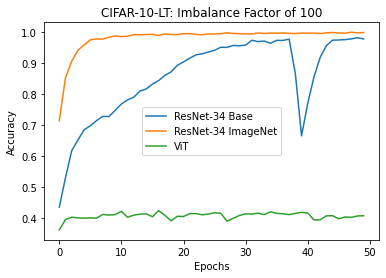

In [ ]:
x = list(range(50)) # Number of epochs to plot

plt.plot(x, res34_accs, label = "ResNet-34 Base")
plt.plot(x, pre_res34_accs, label = "ResNet-34 ImageNet")
plt.plot(x, vit_accs, label = "ViT")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CIFAR-10-LT: Imbalance Factor of 100")
plt.legend()
plt.show()

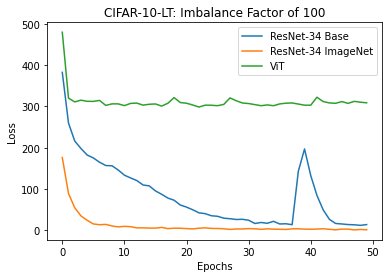

In [ ]:
plt.plot(x, res34_losses, label = "ResNet-34 Base")
plt.plot(x, pre_res34_losses, label = "ResNet-34 ImageNet")
plt.plot(x, vit_losses, label = "ViT")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CIFAR-10-LT: Imbalance Factor of 100")
plt.legend()
plt.show()

Test Results

Test Accuracy =  0.7570621468926554


[Text(69.0, 0.5, 'True Class'),
 Text(0.5, 42.0, 'Predicted Class'),
 Text(0.5, 1.0, 'Base ResNet-34 on CIFAR-10-LT Imbalance Factor of 100')]

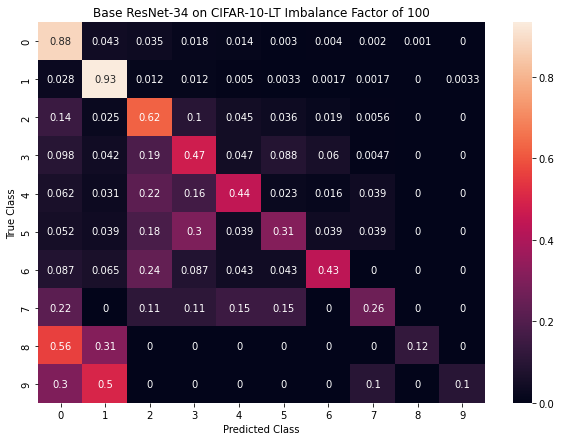

In [ ]:
print("Test Accuracy = ", accuracy_score(res34_targets, res34_preds))
res34_cm = confusion_matrix(res34_targets, res34_preds, normalize='true')
res34_df_cm = pd.DataFrame(res34_cm, index = list(range(10)), columns=list(range(10)))
plt.figure(figsize = (10,7))
ax = sn.heatmap(res34_df_cm, annot=True)
ax.set(xlabel="Predicted Class", ylabel="True Class", title="Base ResNet-34 on CIFAR-10-LT Imbalance Factor of 100")

Test Accuracy =  0.8579499596448749


[Text(69.0, 0.5, 'True Class'),
 Text(0.5, 42.0, 'Predicted Class'),
 Text(0.5, 1.0, 'ImageNet ResNet-34 on CIFAR-10-LT Imbalance Factor of 100')]

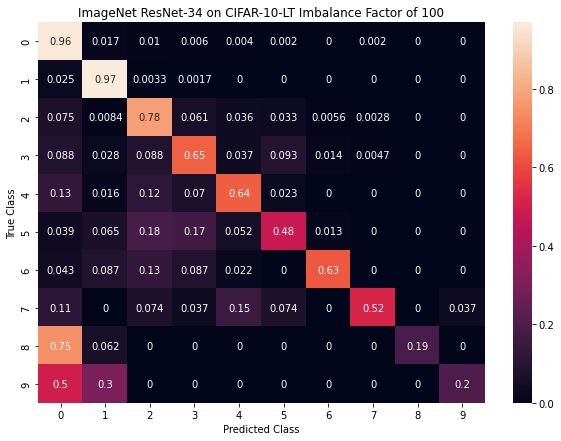

In [ ]:
print("Test Accuracy = ", accuracy_score(pre_res34_targets, pre_res34_preds))
pre_res34_cm = confusion_matrix(pre_res34_targets, pre_res34_preds, normalize='true')
pre_res34_df_cm = pd.DataFrame(pre_res34_cm, index = list(range(10)), columns=list(range(10)))
plt.figure(figsize = (10,7))
ax = sn.heatmap(pre_res34_df_cm, annot=True)
ax.set(xlabel="Predicted Class", ylabel="True Class", title="ImageNet ResNet-34 on CIFAR-10-LT Imbalance Factor of 100")

Test Accuracy =  0.4180790960451977


[Text(69.0, 0.5, 'True Class'),
 Text(0.5, 42.0, 'Predicted Class'),
 Text(0.5, 1.0, 'Base ViT on CIFAR-10-LT Imbalance Factor of 100')]

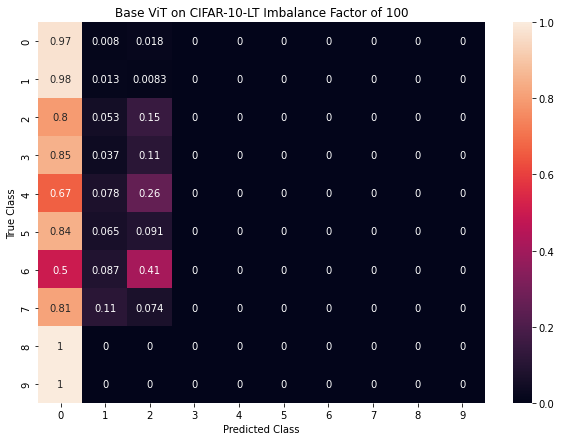

In [ ]:
print("Test Accuracy = ", accuracy_score(vit_targets, vit_preds))
vit_cm = confusion_matrix(vit_targets, vit_preds, normalize='true')
vit_df_cm = pd.DataFrame(vit_cm, index = list(range(10)), columns=list(range(10)))
plt.figure(figsize = (10,7))
ax = sn.heatmap(vit_df_cm, annot=True)
ax.set(xlabel="Predicted Class", ylabel="True Class", title="Base ViT on CIFAR-10-LT Imbalance Factor of 100")

### CIFAR-100-LT

#### ResNet Models

In [ ]:
from torchvision.models import resnet34, ResNet34_Weights

ResNet-34 Trained from Scratch

In [ ]:
res34_model100 = resnet34(weights=None, num_classes=100)
res34_opt100 = torch.optim.Adam(res34_model100.parameters(), lr=0.01)

res34_accs100, res34_losses100 = basic_train(res34_model100, cifar100_train_loader, res34_opt100, criterion, n_epochs=50)
print("-"*20)
print("Best Accuracy =", max(res34_accs100))

Epoch 0


100%|██████████| 170/170 [00:16<00:00, 10.55it/s]


Loss = 752.6443004608154
Accuracy = 0.051903752189545495
Epoch 1


100%|██████████| 170/170 [00:14<00:00, 12.00it/s]


Loss = 671.6448750495911
Accuracy = 0.06066193417534802
Epoch 2


100%|██████████| 170/170 [00:22<00:00,  7.43it/s]


Loss = 643.375363111496
Accuracy = 0.09053194431640085
Epoch 3


100%|██████████| 170/170 [00:18<00:00,  9.26it/s]


Loss = 609.6169474124908
Accuracy = 0.13100396422974095
Epoch 4


100%|██████████| 170/170 [00:15<00:00, 10.85it/s]


Loss = 584.3647511005402
Accuracy = 0.16207246243200885
Epoch 5


100%|██████████| 170/170 [00:13<00:00, 12.23it/s]


Loss = 555.2229070663452
Accuracy = 0.2007006545588642
Epoch 6


100%|██████████| 170/170 [00:13<00:00, 12.36it/s]


Loss = 531.0275113582611
Accuracy = 0.23305983221167142
Epoch 7


100%|██████████| 170/170 [00:13<00:00, 12.40it/s]


Loss = 509.3014438152313
Accuracy = 0.25914999539043054
Epoch 8


100%|██████████| 170/170 [00:14<00:00, 11.96it/s]


Loss = 485.86884689331055
Accuracy = 0.2891121969208076
Epoch 9


100%|██████████| 170/170 [00:14<00:00, 11.85it/s]


Loss = 457.66532588005066
Accuracy = 0.3232230109707753
Epoch 10


100%|██████████| 170/170 [00:13<00:00, 12.43it/s]


Loss = 428.81581377983093
Accuracy = 0.3553978058449341
Epoch 11


100%|██████████| 170/170 [00:14<00:00, 11.91it/s]


Loss = 420.6200672388077
Accuracy = 0.37199225592329677
Epoch 12


100%|██████████| 170/170 [00:13<00:00, 12.26it/s]


Loss = 391.7713053226471
Accuracy = 0.4031529455148889
Epoch 13


100%|██████████| 170/170 [00:14<00:00, 11.87it/s]


Loss = 362.97196912765503
Accuracy = 0.4418733290310685
Epoch 14


100%|██████████| 170/170 [00:13<00:00, 12.35it/s]


Loss = 354.2518233060837
Accuracy = 0.44795796072646815
Epoch 15


100%|██████████| 170/170 [00:13<00:00, 12.35it/s]


Loss = 309.2514933347702
Accuracy = 0.5133216557573522
Epoch 16


100%|██████████| 170/170 [00:13<00:00, 12.25it/s]


Loss = 270.52971267700195
Accuracy = 0.5571125656863649
Epoch 17


100%|██████████| 170/170 [00:13<00:00, 12.31it/s]


Loss = 251.0419184565544
Accuracy = 0.5844012169263391
Epoch 18


100%|██████████| 170/170 [00:14<00:00, 11.86it/s]


Loss = 273.24876487255096
Accuracy = 0.558679819304877
Epoch 19


100%|██████████| 170/170 [00:13<00:00, 12.36it/s]


Loss = 232.77708673477173
Accuracy = 0.6133493131741495
Epoch 20


100%|██████████| 170/170 [00:13<00:00, 12.38it/s]


Loss = 196.06084597110748
Accuracy = 0.6705079745551765
Epoch 21


100%|██████████| 170/170 [00:13<00:00, 12.33it/s]


Loss = 153.82434564828873
Accuracy = 0.7307089517839034
Epoch 22


100%|██████████| 170/170 [00:13<00:00, 12.41it/s]


Loss = 208.12643086910248
Accuracy = 0.6777910943117913
Epoch 23


100%|██████████| 170/170 [00:13<00:00, 12.39it/s]


Loss = 214.45900565385818
Accuracy = 0.637226883009127
Epoch 24


100%|██████████| 170/170 [00:13<00:00, 12.37it/s]


Loss = 138.58671388030052
Accuracy = 0.7588273255277957
Epoch 25


100%|██████████| 170/170 [00:13<00:00, 12.32it/s]


Loss = 101.8215021789074
Accuracy = 0.8181985802526044
Epoch 26


100%|██████████| 170/170 [00:13<00:00, 12.30it/s]


Loss = 83.35510376095772
Accuracy = 0.8483451645616299
Epoch 27


100%|██████████| 170/170 [00:13<00:00, 12.30it/s]


Loss = 51.332686364650726
Accuracy = 0.9058725914999539
Epoch 28


100%|██████████| 170/170 [00:14<00:00, 11.89it/s]


Loss = 43.73245166987181
Accuracy = 0.9168433668295382
Epoch 29


100%|██████████| 170/170 [00:14<00:00, 11.64it/s]


Loss = 41.80911745503545
Accuracy = 0.9215451276850742
Epoch 30


100%|██████████| 170/170 [00:13<00:00, 12.40it/s]


Loss = 39.011007353663445
Accuracy = 0.9256937402046649
Epoch 31


100%|██████████| 170/170 [00:13<00:00, 12.27it/s]


Loss = 36.95761304348707
Accuracy = 0.9291048216096617
Epoch 32


100%|██████████| 170/170 [00:13<00:00, 12.30it/s]


Loss = 36.64235929772258
Accuracy = 0.9293813957776343
Epoch 33


100%|██████████| 170/170 [00:14<00:00, 11.82it/s]


Loss = 33.6094125919044
Accuracy = 0.9352816446943856
Epoch 34


100%|██████████| 170/170 [00:13<00:00, 12.29it/s]


Loss = 34.10517564788461
Accuracy = 0.935466027473034
Epoch 35


100%|██████████| 170/170 [00:13<00:00, 12.36it/s]


Loss = 40.38298483192921
Accuracy = 0.9220982760210197
Epoch 36


100%|██████████| 170/170 [00:13<00:00, 12.25it/s]


Loss = 27.602982308715582
Accuracy = 0.9469899511385637
Epoch 37


100%|██████████| 170/170 [00:14<00:00, 11.86it/s]


Loss = 27.97552042081952
Accuracy = 0.9484650133677515
Epoch 38


100%|██████████| 170/170 [00:13<00:00, 12.28it/s]


Loss = 23.335564193315804
Accuracy = 0.9563012814603116
Epoch 39


100%|██████████| 170/170 [00:13<00:00, 12.35it/s]


Loss = 22.09196797758341
Accuracy = 0.957591960910851
Epoch 40


100%|██████████| 170/170 [00:13<00:00, 12.41it/s]


Loss = 23.991674100980163
Accuracy = 0.954918410620448
Epoch 41


100%|██████████| 170/170 [00:13<00:00, 12.35it/s]


Loss = 23.262162406928837
Accuracy = 0.9571310039642298
Epoch 42


100%|██████████| 170/170 [00:14<00:00, 11.82it/s]


Loss = 25.951648636721075
Accuracy = 0.9526136258873421
Epoch 43


100%|██████████| 170/170 [00:13<00:00, 12.30it/s]


Loss = 24.663293314166367
Accuracy = 0.9535355397805845
Epoch 44


100%|██████████| 170/170 [00:13<00:00, 12.19it/s]


Loss = 24.45975782070309
Accuracy = 0.953719922559233
Epoch 45


100%|██████████| 170/170 [00:13<00:00, 12.37it/s]


Loss = 24.597381097264588
Accuracy = 0.9530745828339633
Epoch 46


100%|██████████| 170/170 [00:13<00:00, 12.33it/s]


Loss = 21.56163297686726
Accuracy = 0.9577763436894994
Epoch 47


100%|██████████| 170/170 [00:15<00:00, 11.33it/s]


Loss = 24.600229548290372
Accuracy = 0.9551949847884208
Epoch 48


100%|██████████| 170/170 [00:13<00:00, 12.19it/s]


Loss = 20.19987143855542
Accuracy = 0.9611874250944962
Epoch 49


100%|██████████| 170/170 [00:13<00:00, 12.21it/s]


Loss = 21.98446026351303
Accuracy = 0.95952798008666
--------------------
Best Accuracy = 0.9611874250944962


In [ ]:
res34_preds100, res34_targets100 = basic_test(res34_model100, cifar100_test_loader, criterion)

100%|██████████| 34/34 [00:00<00:00, 35.13it/s]


Test Loss =  212.71840393543243


Finetuning with ImageNet Pretrained ResNet-34

In [ ]:
pre_res34_model100 = resnet34(weights=ResNet34_Weights.DEFAULT)
pre_res34_model100.fc = nn.Linear(512, 100)
  
pre_res34_opt100 = torch.optim.Adam(pre_res34_model100.parameters(), lr=1e-4)

pre_res34_accs100, pre_res34_losses100 = basic_train(pre_res34_model100, cifar100_train_loader, pre_res34_opt100, criterion, n_epochs=50)
print("-"*20)
print("Best Accuracy =", max(pre_res34_accs100))

Epoch 0


100%|██████████| 170/170 [00:14<00:00, 11.99it/s]


Loss = 548.0465793609619
Accuracy = 0.2776804646446022
Epoch 1


100%|██████████| 170/170 [00:14<00:00, 11.81it/s]


Loss = 323.8485424518585
Accuracy = 0.5194984788420761
Epoch 2


100%|██████████| 170/170 [00:13<00:00, 12.27it/s]


Loss = 220.98489439487457
Accuracy = 0.6574167972711349
Epoch 3


100%|██████████| 170/170 [00:13<00:00, 12.29it/s]


Loss = 153.65507525205612
Accuracy = 0.7579976030238775
Epoch 4


100%|██████████| 170/170 [00:13<00:00, 12.31it/s]


Loss = 102.52001130580902
Accuracy = 0.8426292984235273
Epoch 5


100%|██████████| 170/170 [00:13<00:00, 12.15it/s]


Loss = 68.88776570558548
Accuracy = 0.8960081128422606
Epoch 6


100%|██████████| 170/170 [00:14<00:00, 11.84it/s]


Loss = 45.234259605407715
Accuracy = 0.9376786208168157
Epoch 7


100%|██████████| 170/170 [00:13<00:00, 12.22it/s]


Loss = 31.258945643901825
Accuracy = 0.9563012814603116
Epoch 8


100%|██████████| 170/170 [00:13<00:00, 12.37it/s]


Loss = 24.08343581110239
Accuracy = 0.9668110998432746
Epoch 9


100%|██████████| 170/170 [00:13<00:00, 12.32it/s]


Loss = 22.69108629412949
Accuracy = 0.9703143726375957
Epoch 10


100%|██████████| 170/170 [00:14<00:00, 11.89it/s]


Loss = 21.160855285823345
Accuracy = 0.9687471190190836
Epoch 11


100%|██████████| 170/170 [00:13<00:00, 12.23it/s]


Loss = 19.13983005285263
Accuracy = 0.9709597123628653
Epoch 12


100%|██████████| 170/170 [00:13<00:00, 12.43it/s]


Loss = 15.855120526626706
Accuracy = 0.9775974923942103
Epoch 13


100%|██████████| 170/170 [00:13<00:00, 12.35it/s]


Loss = 13.621802607551217
Accuracy = 0.9799944685166405
Epoch 14


100%|██████████| 170/170 [00:13<00:00, 12.31it/s]


Loss = 12.98915549274534
Accuracy = 0.9804554254632617
Epoch 15


100%|██████████| 170/170 [00:14<00:00, 11.38it/s]


Loss = 15.814592521637678
Accuracy = 0.9749239421038075
Epoch 16


100%|██████████| 170/170 [00:13<00:00, 12.23it/s]


Loss = 13.031831294298172
Accuracy = 0.9796257029593436
Epoch 17


100%|██████████| 170/170 [00:13<00:00, 12.42it/s]


Loss = 17.42539856210351
Accuracy = 0.9704987554162441
Epoch 18


100%|██████████| 170/170 [00:13<00:00, 12.30it/s]


Loss = 21.01204297877848
Accuracy = 0.9652438462247626
Epoch 19


100%|██████████| 170/170 [00:14<00:00, 11.91it/s]


Loss = 15.290536574553698
Accuracy = 0.9744629851571863
Epoch 20


100%|██████████| 170/170 [00:13<00:00, 12.29it/s]


Loss = 12.337853018194437
Accuracy = 0.9799944685166405
Epoch 21


100%|██████████| 170/170 [00:13<00:00, 12.31it/s]


Loss = 11.482636267319322
Accuracy = 0.9811007651885314
Epoch 22


100%|██████████| 170/170 [00:13<00:00, 12.37it/s]


Loss = 9.114765780512244
Accuracy = 0.9848806121508251
Epoch 23


100%|██████████| 170/170 [00:13<00:00, 12.24it/s]


Loss = 8.496966026723385
Accuracy = 0.9861712916013644
Epoch 24


100%|██████████| 170/170 [00:14<00:00, 11.95it/s]


Loss = 9.532542007043958
Accuracy = 0.9842352724255554
Epoch 25


100%|██████████| 170/170 [00:13<00:00, 12.21it/s]


Loss = 10.571043644566089
Accuracy = 0.9819304876924495
Epoch 26


100%|██████████| 170/170 [00:13<00:00, 12.25it/s]


Loss = 10.494201461784542
Accuracy = 0.982114870471098
Epoch 27


100%|██████████| 170/170 [00:13<00:00, 12.16it/s]


Loss = 11.676445817109197
Accuracy = 0.9791647460127224
Epoch 28


100%|██████████| 170/170 [00:13<00:00, 12.32it/s]


Loss = 11.351428968831897
Accuracy = 0.9807319996312345
Epoch 29


100%|██████████| 170/170 [00:14<00:00, 11.64it/s]


Loss = 9.76181190693751
Accuracy = 0.9820226790817738
Epoch 30


100%|██████████| 170/170 [00:13<00:00, 12.34it/s]


Loss = 9.401510420255363
Accuracy = 0.9837743154789342
Epoch 31


100%|██████████| 170/170 [00:13<00:00, 12.37it/s]


Loss = 7.569392501842231
Accuracy = 0.9873697796625795
Epoch 32


100%|██████████| 170/170 [00:14<00:00, 11.95it/s]


Loss = 6.419171744841151
Accuracy = 0.9902277127316309
Epoch 33


100%|██████████| 170/170 [00:14<00:00, 11.91it/s]


Loss = 7.110917991027236
Accuracy = 0.9892136074490643
Epoch 34


100%|██████████| 170/170 [00:14<00:00, 12.01it/s]


Loss = 7.915950287599117
Accuracy = 0.9868166313266341
Epoch 35


100%|██████████| 170/170 [00:13<00:00, 12.44it/s]


Loss = 5.7431854049209505
Accuracy = 0.9893057988383885
Epoch 36


100%|██████████| 170/170 [00:13<00:00, 12.18it/s]


Loss = 5.657894524745643
Accuracy = 0.9900433299529824
Epoch 37


100%|██████████| 170/170 [00:13<00:00, 12.38it/s]


Loss = 11.037438413128257
Accuracy = 0.9819304876924495
Epoch 38


100%|██████████| 170/170 [00:14<00:00, 11.82it/s]


Loss = 10.697560862172395
Accuracy = 0.9807319996312345
Epoch 39


100%|██████████| 170/170 [00:13<00:00, 12.38it/s]


Loss = 8.40613198140636
Accuracy = 0.9851571863187978
Epoch 40


100%|██████████| 170/170 [00:13<00:00, 12.24it/s]


Loss = 7.588821801939048
Accuracy = 0.9861712916013644
Epoch 41


100%|██████████| 170/170 [00:13<00:00, 12.34it/s]


Loss = 5.973004176747054
Accuracy = 0.9902277127316309
Epoch 42


100%|██████████| 170/170 [00:13<00:00, 12.30it/s]


Loss = 6.070161458803341
Accuracy = 0.9898589471743339
Epoch 43


100%|██████████| 170/170 [00:14<00:00, 11.84it/s]


Loss = 6.805730351130478
Accuracy = 0.9870010141052825
Epoch 44


100%|██████████| 170/170 [00:13<00:00, 12.30it/s]


Loss = 8.517121252603829
Accuracy = 0.9851571863187978
Epoch 45


100%|██████████| 170/170 [00:13<00:00, 12.21it/s]


Loss = 9.14191759401001
Accuracy = 0.985249377708122
Epoch 46


100%|██████████| 170/170 [00:13<00:00, 12.32it/s]


Loss = 8.335104207508266
Accuracy = 0.9858947174333917
Epoch 47


100%|██████████| 170/170 [00:14<00:00, 12.09it/s]


Loss = 8.264934483217075
Accuracy = 0.9858025260440675
Epoch 48


100%|██████████| 170/170 [00:14<00:00, 11.93it/s]


Loss = 7.764703522785567
Accuracy = 0.9872775882732553
Epoch 49


100%|██████████| 170/170 [00:14<00:00, 12.13it/s]


Loss = 7.538159996038303
Accuracy = 0.9864478657693372
--------------------
Best Accuracy = 0.9902277127316309


In [ ]:
pre_res34_preds100, pre_res34_targets100 = basic_test(pre_res34_model100, cifar100_test_loader, criterion)

100%|██████████| 34/34 [00:00<00:00, 35.46it/s]


Test Loss =  97.62417495250702


#### Vision Transformer

From Scratch

In [ ]:
from vit_pytorch import ViT

vit_model100 = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 100,
    dim = 256,
    depth = 3,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
)

vit_opt100 = torch.optim.Adam(vit_model100.parameters(), lr=0.07)

vit_accs100, vit_losses100 = basic_train(vit_model100, cifar100_train_loader, vit_opt100, criterion, n_epochs=50)
print("Best Accuracy =", max(vit_accs100))

Epoch 0


100%|██████████| 170/170 [00:09<00:00, 18.42it/s]


Loss = 854.9267086982727
Accuracy = 0.0340186226606435
Epoch 1


100%|██████████| 170/170 [00:09<00:00, 17.43it/s]


Loss = 706.0735332965851
Accuracy = 0.03761408684428874
Epoch 2


100%|██████████| 170/170 [00:09<00:00, 18.38it/s]


Loss = 707.466587305069
Accuracy = 0.03494053655388587
Epoch 3


100%|██████████| 170/170 [00:09<00:00, 17.62it/s]


Loss = 712.3190715312958
Accuracy = 0.04176269936387941
Epoch 4


100%|██████████| 170/170 [00:09<00:00, 18.46it/s]


Loss = 713.517728805542
Accuracy = 0.042684613257121785
Epoch 5


100%|██████████| 170/170 [00:09<00:00, 18.23it/s]


Loss = 718.7827217578888
Accuracy = 0.043237761593067206
Epoch 6


100%|██████████| 170/170 [00:09<00:00, 18.60it/s]


Loss = 718.1254870891571
Accuracy = 0.043698718539688396
Epoch 7


100%|██████████| 170/170 [00:09<00:00, 18.45it/s]


Loss = 707.8480796813965
Accuracy = 0.052364709136166684
Epoch 8


100%|██████████| 170/170 [00:09<00:00, 18.34it/s]


Loss = 700.8443264961243
Accuracy = 0.0568820872130543
Epoch 9


100%|██████████| 170/170 [00:09<00:00, 18.34it/s]


Loss = 696.3584597110748
Accuracy = 0.05854153222089057
Epoch 10


100%|██████████| 170/170 [00:09<00:00, 17.42it/s]


Loss = 696.899331331253
Accuracy = 0.05328662302940905
Epoch 11


100%|██████████| 170/170 [00:09<00:00, 18.21it/s]


Loss = 696.0976538658142
Accuracy = 0.06001659445007836
Epoch 12


100%|██████████| 170/170 [00:09<00:00, 18.33it/s]


Loss = 699.0241866111755
Accuracy = 0.05605236470913617
Epoch 13


100%|██████████| 170/170 [00:09<00:00, 18.48it/s]


Loss = 697.6107003688812
Accuracy = 0.05789619249562091
Epoch 14


100%|██████████| 170/170 [00:09<00:00, 18.39it/s]


Loss = 696.7583243846893
Accuracy = 0.06066193417534802
Epoch 15


100%|██████████| 170/170 [00:09<00:00, 18.27it/s]


Loss = 699.1680297851562
Accuracy = 0.05854153222089057
Epoch 16


100%|██████████| 170/170 [00:09<00:00, 18.18it/s]


Loss = 693.1049709320068
Accuracy = 0.061952613625887346
Epoch 17


100%|██████████| 170/170 [00:09<00:00, 17.54it/s]


Loss = 706.188746213913
Accuracy = 0.05798838388494515
Epoch 18


100%|██████████| 170/170 [00:09<00:00, 18.23it/s]


Loss = 695.3580853939056
Accuracy = 0.06499492947358716
Epoch 19


100%|██████████| 170/170 [00:09<00:00, 18.39it/s]


Loss = 693.6308898925781
Accuracy = 0.06481054669493869
Epoch 20


100%|██████████| 170/170 [00:09<00:00, 18.31it/s]


Loss = 693.6043791770935
Accuracy = 0.06508712086291141
Epoch 21


100%|██████████| 170/170 [00:09<00:00, 18.33it/s]


Loss = 690.1324033737183
Accuracy = 0.06895915921452936
Epoch 22


100%|██████████| 170/170 [00:09<00:00, 18.45it/s]


Loss = 691.3609223365784
Accuracy = 0.06637780031345072
Epoch 23


100%|██████████| 170/170 [00:09<00:00, 18.35it/s]


Loss = 695.8186423778534
Accuracy = 0.06674656587074768
Epoch 24


100%|██████████| 170/170 [00:09<00:00, 17.38it/s]


Loss = 689.8129594326019
Accuracy = 0.06748409698534157
Epoch 25


100%|██████████| 170/170 [00:09<00:00, 18.22it/s]


Loss = 687.7883548736572
Accuracy = 0.07495159952060478
Epoch 26


100%|██████████| 170/170 [00:09<00:00, 18.36it/s]


Loss = 683.3860726356506
Accuracy = 0.075043790909929
Epoch 27


100%|██████████| 170/170 [00:09<00:00, 18.51it/s]


Loss = 683.5136439800262
Accuracy = 0.07458283396330782
Epoch 28


100%|██████████| 170/170 [00:09<00:00, 17.36it/s]


Loss = 705.7977051734924
Accuracy = 0.061583848068590394
Epoch 29


100%|██████████| 170/170 [00:09<00:00, 18.39it/s]


Loss = 690.7545375823975
Accuracy = 0.07071079561168987
Epoch 30


100%|██████████| 170/170 [00:09<00:00, 18.46it/s]


Loss = 678.5451805591583
Accuracy = 0.0755047478565502
Epoch 31


100%|██████████| 170/170 [00:09<00:00, 17.40it/s]


Loss = 679.7500293254852
Accuracy = 0.08094403982668019
Epoch 32


100%|██████████| 170/170 [00:09<00:00, 18.40it/s]


Loss = 683.4045052528381
Accuracy = 0.08085184843735595
Epoch 33


100%|██████████| 170/170 [00:09<00:00, 18.06it/s]


Loss = 685.6125299930573
Accuracy = 0.07688761869641375
Epoch 34


100%|██████████| 170/170 [00:09<00:00, 18.28it/s]


Loss = 684.2431943416595
Accuracy = 0.07661104452844104
Epoch 35


100%|██████████| 170/170 [00:09<00:00, 18.44it/s]


Loss = 693.3136918544769
Accuracy = 0.07356872868074121
Epoch 36


100%|██████████| 170/170 [00:09<00:00, 18.34it/s]


Loss = 697.3568789958954
Accuracy = 0.0732921545127685
Epoch 37


100%|██████████| 170/170 [00:09<00:00, 18.16it/s]


Loss = 685.2362961769104
Accuracy = 0.07688761869641375
Epoch 38


100%|██████████| 170/170 [00:09<00:00, 17.38it/s]


Loss = 682.9370648860931
Accuracy = 0.07965336037614087
Epoch 39


100%|██████████| 170/170 [00:09<00:00, 18.42it/s]


Loss = 679.625186920166
Accuracy = 0.08232691066654374
Epoch 40


100%|██████████| 170/170 [00:09<00:00, 18.43it/s]


Loss = 674.5342745780945
Accuracy = 0.08758181985802527
Epoch 41


100%|██████████| 170/170 [00:09<00:00, 18.26it/s]


Loss = 679.6807208061218
Accuracy = 0.08223471927721951
Epoch 42


100%|██████████| 170/170 [00:09<00:00, 18.29it/s]


Loss = 673.1977968215942
Accuracy = 0.08555360929289205
Epoch 43


100%|██████████| 170/170 [00:09<00:00, 18.31it/s]


Loss = 673.50133061409
Accuracy = 0.08315663317046187
Epoch 44


100%|██████████| 170/170 [00:09<00:00, 18.13it/s]


Loss = 678.8306429386139
Accuracy = 0.08389416428505578
Epoch 45


100%|██████████| 170/170 [00:09<00:00, 18.27it/s]


Loss = 674.2882523536682
Accuracy = 0.08758181985802527
Epoch 46


100%|██████████| 170/170 [00:09<00:00, 17.32it/s]


Loss = 677.9915130138397
Accuracy = 0.0779939153683046
Epoch 47


100%|██████████| 170/170 [00:09<00:00, 18.08it/s]


Loss = 683.0099408626556
Accuracy = 0.07965336037614087
Epoch 48


100%|██████████| 170/170 [00:09<00:00, 18.27it/s]


Loss = 679.8886294364929
Accuracy = 0.07863925509357426
Epoch 49


100%|██████████| 170/170 [00:09<00:00, 18.25it/s]

Loss = 677.1314225196838
Accuracy = 0.0834332073384346
Best Accuracy = 0.08758181985802527


In [ ]:
vit_preds100, vit_targets100 = basic_test(vit_model100, cifar100_test_loader, criterion)

100%|██████████| 34/34 [00:00<00:00, 41.07it/s]

Test Loss =  135.56109046936035


Visualize Training of CIFAR-100


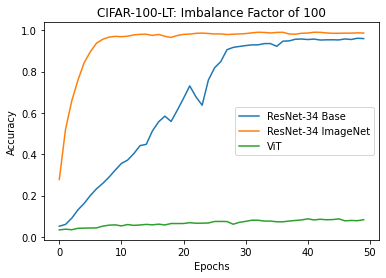

In [ ]:
x = list(range(50)) # Number of epochs to plot

plt.plot(x, res34_accs100, label = "ResNet-34 Base")
plt.plot(x, pre_res34_accs100, label = "ResNet-34 ImageNet")
plt.plot(x, vit_accs100, label = "ViT")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CIFAR-100-LT: Imbalance Factor of 100")
plt.legend()
plt.show()

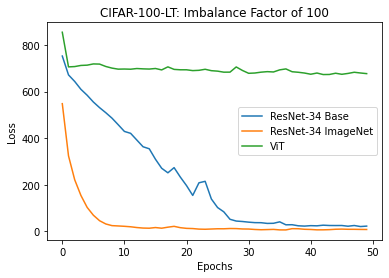

In [ ]:
plt.plot(x, res34_losses100, label = "ResNet-34 Base")
plt.plot(x, pre_res34_losses100, label = "ResNet-34 ImageNet")
plt.plot(x, vit_losses100, label = "ViT")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CIFAR-100-LT: Imbalance Factor of 100")
plt.legend()
plt.show()

##### Test Results

In [ ]:
many_classes = [i for i, num_cls in enumerate(cifar100_trainDataset.get_cls_num_list()) if num_cls > 100]
medium_classes = [i for i, num_cls in enumerate(cifar100_trainDataset.get_cls_num_list()) if 20 <= num_cls <= 100]
few_classes = [i for i, num_cls in enumerate(cifar100_trainDataset.get_cls_num_list()) if num_cls < 20]

Base ResNet-34

In [ ]:
print("Test Accuracy = ", accuracy_score(res34_targets100, res34_preds100))

res34_cm100 = confusion_matrix(res34_targets100, res34_preds100, normalize='true')
print("Many Accuracy = ", np.mean([res34_cm100[cls, cls] for cls in many_classes]))
print("Medium Accuracy = ", np.mean([res34_cm100[cls, cls] for cls in medium_classes]))
print("Few Accuracy = ", np.mean([res34_cm100[cls, cls] for cls in few_classes]))

Test Accuracy =  0.38104176442984516
Many Accuracy =  0.40530215947878345
Medium Accuracy =  0.13576118608405205
Few Accuracy =  0.027777777777777776


Pretrained ResNet-34

In [ ]:
print("Test Accuracy = ", accuracy_score(pre_res34_targets100, pre_res34_preds100))

pre_res34_cm100 = confusion_matrix(pre_res34_targets100, pre_res34_preds100, normalize='true')
print("Many Accuracy = ", np.mean([pre_res34_cm100[cls, cls] for cls in many_classes]))
print("Medium Accuracy = ", np.mean([pre_res34_cm100[cls, cls] for cls in medium_classes]))
print("Few Accuracy = ", np.mean([pre_res34_cm100[cls, cls] for cls in few_classes]))

Test Accuracy =  0.5631159080244017
Many Accuracy =  0.5941801029625913
Medium Accuracy =  0.2693812768635856
Few Accuracy =  0.07777777777777777


ViT

In [ ]:
print("Test Accuracy = ", accuracy_score(vit_targets100, vit_preds100))

vit_cm100 = confusion_matrix(vit_targets100, vit_preds100, normalize='true')
print("Many Accuracy = ", np.mean([vit_cm100[cls, cls] for cls in many_classes]))
print("Medium Accuracy = ", np.mean([vit_cm100[cls, cls] for cls in medium_classes]))
print("Few Accuracy = ", np.mean([vit_cm100[cls, cls] for cls in few_classes]))

Test Accuracy =  0.1018301267010793
Many Accuracy =  0.10220025352106499
Medium Accuracy =  0.007142857142857143
Few Accuracy =  0.0


In [ ]:
# TODO: 3x3 confusion matrix for many, medium, few

## BCL Paper Models

In [10]:
from models import resnets
from loss.contrastive import BalSCL
from loss.logitadjust import LogitAdjust
from randaugment import rand_augment_transform
from cutout import Cutout

ra_params = dict(translate_const=int(224 * 0.45), img_mean=tuple([min(255, round(255 * x)) for x in (0.485, 0.456, 0.406)]), )

augmentation_randncls = [
        transforms.RandomResizedCrop(224, scale=(0.08, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.0)
        ], p=1.0),
        rand_augment_transform('rand-n{}-m{}-mstd0.5'.format(2, 10), ra_params),
        transforms.ToTensor(),
        Cutout(4, 6),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]

augmentation_randnclsstack = [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        rand_augment_transform('rand-n{}-m{}-mstd0.5'.format(2, 10), ra_params),
        transforms.ToTensor(),
        Cutout(4, 6),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]

augmentation_sim = [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]

transform_train = [transforms.Compose(augmentation_randncls), transforms.Compose(augmentation_randnclsstack), transforms.Compose(augmentation_sim), ]
transform_val = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

alpha = 2.0
beta = 0.6

In [11]:
def train_BCL(model, train_loader, optimizer, ce_criterion, scl_criterion, cls_num, n_epochs=100):
    model.to(device)
    model.train()

    accs = []
    losses = []

    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_correct = 0
        num_preds = 0

        print("Epoch:", epoch)
        for inputs, targets in tqdm(train_loader):
            optimizer.zero_grad()

            inputs = torch.cat([inputs[0], inputs[1], inputs[2]], dim=0)
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = targets.shape[0]
            feat_mlp, logits, centers = model(inputs)
            centers = centers[:cls_num]
            _, f2, f3 = torch.split(feat_mlp, [batch_size, batch_size, batch_size], dim=0)
            features = torch.cat([f2.unsqueeze(1), f3.unsqueeze(1)], dim=1)
            logits, _, __ = torch.split(logits, [batch_size, batch_size, batch_size], dim=0)
            scl_loss = criterion_scl(centers, features, targets)
            ce_loss = criterion_ce(logits, targets)
            
            loss = alpha * ce_loss + beta * scl_loss
            epoch_loss += loss.item()

            epoch_correct += torch.sum(torch.argmax(logits, dim=1) == targets).item()
            num_preds += batch_size

            loss.backward()
            optimizer.step()
      
        epoch_acc = epoch_correct / num_preds
        accs += [epoch_acc]
        losses += [epoch_loss]

        print(f"Loss = {epoch_loss}")
        print(f"Accuracy = {epoch_acc}")

    model.cpu()
    return accs, losses


def validate_BCL(model, val_loader, criterion):
    model.to(device)
    model.eval()

    preds = []
    labels = []

    epoch_adj_loss = 0
    epoch_loss = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = targets.size(0)
            feat_mlp, logits, centers = model(inputs)

            ce_loss = criterion_ce(logits, targets)
            epoch_adj_loss += ce_loss.item()
            loss = criterion(logits, targets)
            epoch_loss += loss.item()

            preds += torch.argmax(logits, dim=1).view(-1).cpu().detach().tolist()
            labels += targets.cpu().detach().tolist()

    print("Test Adjusted Classification Loss = ", epoch_adj_loss)
    print("Test Loss = ", epoch_loss)

    model.cpu()
    return preds, labels

CIFAR-10-LT

Weighted CE loss

In [16]:
bcl_cifar10_train = IMBALANCECIFAR10(root='/DATACENTER/3/zjg/cifar', train=True,
                                 download=True, transform=transform_train, bcl=True)
bcl_cifar10_test = IMBALANCECIFAR10(root='/DATACENTER/3/zjg/cifar', train=False,
                                 download=True, transform=transform_val, bcl=True)

bcl_cifar10_train_loader = DataLoader(bcl_cifar10_train, batch_size=1, shuffle=True, pin_memory=True)
bcl_cifar10_test_loader = DataLoader(bcl_cifar10_test, batch_size=1, shuffle=False, pin_memory=True)

cls_num_list = bcl_cifar10_train.get_cls_num_list()
cls_num = len(cls_num_list)

cls_num_list_float=[float(x) for x in cls_num_list]
criterion_ce_weight=torch.from_numpy(np.reciprocal(cls_num_list_float))
print(criterion_ce_weight)

criterion_ce = LogitAdjust(cls_num_list, weight=criterion_ce_weight).to(device)
criterion_scl = BalSCL(cls_num_list, 0.1).to(device) # temperature of 0.1

Files already downloaded and verified
Files already downloaded and verified


RuntimeError: ignored

In [ ]:
bcl_resnet10 = resnets.BCLModel(name='resnet32', num_classes=10, feat_dim=512, use_norm=True)
bcl10_opt = torch.optim.SGD(bcl_resnet10.parameters(), lr=0.1, momentum=0.9)

bcl_accs10, bcl_losses10 = train_BCL(bcl_resnet10, bcl_cifar10_train_loader, bcl10_opt, criterion_ce, criterion_scl, cls_num, n_epochs=100)
print("-"*50)
print("Best Accuracy =", max(bcl_accs10))

Epoch: 0


100%|██████████| 12406/12406 [18:43<00:00, 11.04it/s]


Loss = 53875.48897996545
Accuracy = 0.11526680638400774
Epoch: 1


100%|██████████| 12406/12406 [17:58<00:00, 11.50it/s]


Loss = 47941.10685890913
Accuracy = 0.1493632113493471
Epoch: 2


100%|██████████| 12406/12406 [17:48<00:00, 11.61it/s]


Loss = 46155.837296009064
Accuracy = 0.22158632919555055
Epoch: 3


100%|██████████| 12406/12406 [17:45<00:00, 11.64it/s]


Loss = 43197.50123047829
Accuracy = 0.31186522650330484
Epoch: 4


100%|██████████| 12406/12406 [17:46<00:00, 11.63it/s]


Loss = 40114.60444059968
Accuracy = 0.3453167822021602
Epoch: 5


100%|██████████| 12406/12406 [17:26<00:00, 11.85it/s]


Loss = 37760.821965917945
Accuracy = 0.37699500241818473
Epoch: 6


100%|██████████| 12406/12406 [17:00<00:00, 12.16it/s]


Loss = 35931.82910437137
Accuracy = 0.4002095760116073
Epoch: 7


100%|██████████| 12406/12406 [17:03<00:00, 12.12it/s]


Loss = 35003.89669390023
Accuracy = 0.4077865548927938
Epoch: 8


100%|██████████| 12406/12406 [17:27<00:00, 11.85it/s]


Loss = 33495.4537483044
Accuracy = 0.41802353699822664
Epoch: 9


100%|██████████| 12406/12406 [17:31<00:00, 11.80it/s]


Loss = 32393.619294710457
Accuracy = 0.43954538126712883
Epoch: 10


100%|██████████| 12406/12406 [17:21<00:00, 11.91it/s]


Loss = 31607.926505636424
Accuracy = 0.44945993873931966
Epoch: 11


100%|██████████| 12406/12406 [17:04<00:00, 12.11it/s]


Loss = 30572.90562743321
Accuracy = 0.46735450588424954
Epoch: 12


 42%|████▏     | 5266/12406 [07:13<09:45, 12.20it/s]

In [ ]:
bcl_res_preds, bcl_res_targets = validate_BCL(bcl_resnet10, bcl_cifar10_test_loader, criterion=nn.CrossEntropyLoss())

Test Adjusted Classification Loss =  17.330146484076977
Test Loss =  30.044891729950905


Focal Loss

In [ ]:
from loss.focal import FocalLoss

bcl_cifar10_train = IMBALANCECIFAR10(root='/DATACENTER/3/zjg/cifar', train=True,
                                 download=True, transform=transform_train, bcl=True)
bcl_cifar10_test = IMBALANCECIFAR10(root='/DATACENTER/3/zjg/cifar', train=False,
                                 download=True, transform=transform_val, bcl=True)

bcl_cifar10_train_loader = DataLoader(bcl_cifar10_train, batch_size=1, shuffle=True, pin_memory=True)
bcl_cifar10_test_loader = DataLoader(bcl_cifar10_test, batch_size=1, shuffle=False, pin_memory=True)

cls_num_list = bcl_cifar10_train.get_cls_num_list()
cls_num = len(cls_num_list)


# criterion_ce = LogitAdjust(cls_num_list, weight=criterion_ce_weight).to(device)
criterion_focal=FocalLoss(cls_num_list)
criterion_scl = BalSCL(cls_num_list, 0.1).to(device) # temperature of 0.1

Files already downloaded and verified
Files already downloaded and verified


RuntimeError: ignored

In [ ]:
bcl_resnet10 = resnets.BCLModel(name='resnet32', num_classes=10, feat_dim=512, use_norm=True)
bcl10_opt = torch.optim.SGD(bcl_resnet10.parameters(), lr=0.1, momentum=0.9)

bcl_accs10, bcl_losses10 = train_BCL(bcl_resnet10, bcl_cifar10_train_loader, bcl10_opt, criterion_focal, criterion_scl, cls_num, n_epochs=50)
print("-"*50)
print("Best Accuracy =", max(bcl_accs10))

Visualize Training of CIFAR-10

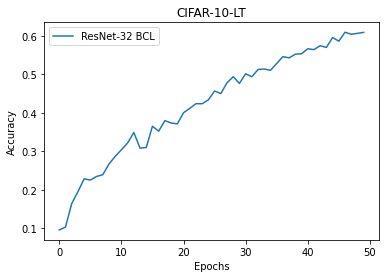

In [ ]:
x = list(range(50)) # Number of epochs to plot

plt.plot(x, bcl_accs10, label = "ResNet-32 BCL")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CIFAR-10-LT")
plt.legend()
plt.show()

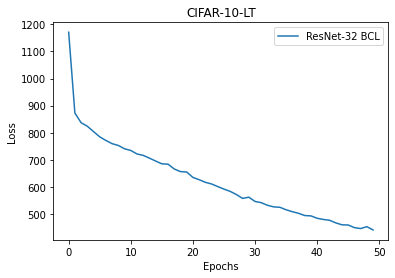

In [ ]:
x = list(range(50)) # Number of epochs to plot

plt.plot(x, bcl_losses10, label = "ResNet-32 BCL")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CIFAR-10-LT")
plt.legend()
plt.show()

Test Results

Test Accuracy =  0.7203389830508474


[Text(69.0, 0.5, 'True Class'),
 Text(0.5, 42.0, 'Predicted Class'),
 Text(0.5, 1.0, 'BCL ResNet-34 on CIFAR-10-LT')]

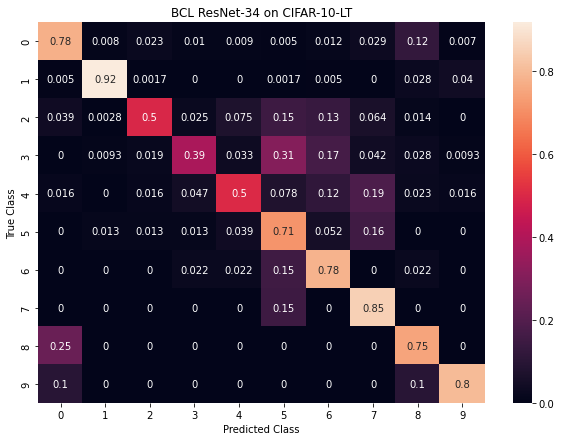

In [ ]:
print("Test Accuracy = ", accuracy_score(bcl_res_targets, bcl_res_preds))
bcl_res_cm = confusion_matrix(bcl_res_targets, bcl_res_preds, normalize='true')
bcl_res_df_cm = pd.DataFrame(bcl_res_cm, index = list(range(10)), columns=list(range(10)))
plt.figure(figsize = (10,7))
ax = sn.heatmap(bcl_res_df_cm, annot=True)
ax.set(xlabel="Predicted Class", ylabel="True Class", title="BCL ResNet-34 on CIFAR-10-LT")

CIFAR-100-LT

In [12]:
bcl_cifar100_train = IMBALANCECIFAR100(root='/DATACENTER/3/zjg/cifar', train=True,
                                 download=True, transform=transform_train, bcl=True)
bcl_cifar100_test = IMBALANCECIFAR100(root='/DATACENTER/3/zjg/cifar', train=False,
                                 download=True, transform=transform_val, bcl=True)

bcl_cifar100_train_loader = DataLoader(bcl_cifar100_train, batch_size=64, shuffle=True, pin_memory=True)
bcl_cifar100_test_loader = DataLoader(bcl_cifar100_test, batch_size=64, shuffle=False, pin_memory=True)

cls_num_list = bcl_cifar100_train.get_cls_num_list()
cls_num = len(cls_num_list)

criterion_ce = LogitAdjust(cls_num_list).to(device)
criterion_scl = BalSCL(cls_num_list, 0.1).to(device)

Files already downloaded and verified
Files already downloaded and verified


RuntimeError: ignored

In [13]:
bcl_resnet100 = resnets.BCLModel(name='resnet32', num_classes=100, feat_dim=512, use_norm=True)
bcl100_opt = torch.optim.SGD(bcl_resnet100.parameters(), lr=0.1, momentum=0.9)

bcl_accs100, bcl_losses100 = train_BCL(bcl_resnet100, bcl_cifar100_train_loader, bcl100_opt, criterion_ce, criterion_scl, cls_num, n_epochs=150)
print("-"*50)
print("Best Accuracy =", max(bcl_accs100))

NameError: ignored

In [19]:
bcl_res100_preds, bcl_res100_targets = validate_BCL(bcl_resnet100, bcl_cifar100_test_loader, criterion=nn.CrossEntropyLoss())

NameError: ignored

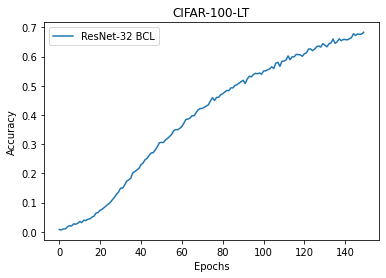

In [ ]:
x = list(range(150)) # Number of epochs to plot

plt.plot(x, bcl_accs100, label = "ResNet-32 BCL")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CIFAR-100-LT")
plt.legend()
plt.show()

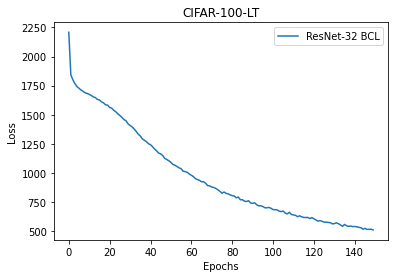

In [ ]:
x = list(range(150)) # Number of epochs to plot

plt.plot(x, bcl_losses100, label = "ResNet-32 BCL")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CIFAR-100-LT")
plt.legend()
plt.show()

Test Results

In [17]:
many_classes = [i for i, num_cls in enumerate(cls_num_list) if num_cls > 100]
medium_classes = [i for i, num_cls in enumerate(cls_num_list) if 20 <= num_cls <= 100]
few_classes = [i for i, num_cls in enumerate(cls_num_list) if num_cls < 20]

In [18]:
print("Test Accuracy = ", accuracy_score(bcl_res100_targets, bcl_res100_preds))

bcl_res100_cm = confusion_matrix(bcl_res100_targets, bcl_res100_preds, normalize='true')
print("Many Accuracy = ", np.mean([bcl_res100_cm[cls, cls] for cls in many_classes]))
print("Medium Accuracy = ", np.mean([bcl_res100_cm[cls, cls] for cls in medium_classes]))
print("Few Accuracy = ", np.mean([bcl_res100_cm[cls, cls] for cls in few_classes]))

NameError: ignored

In [4]:
def compute_acc(cls_num_list,target,pred):
  overall_acc=accuracy_score(target, pred)
  cm = confusion_matrix(target, pred, normalize='true')
  many_classes = [i for i, num_cls in enumerate(cls_num_list) if num_cls > 100]
  medium_classes = [i for i, num_cls in enumerate(cls_num_list) if 20 <= num_cls <= 100]
  few_classes = [i for i, num_cls in enumerate(cls_num_list) if num_cls < 20]
  many_acc=np.mean([cm[cls, cls] for cls in many_classes])
  medium_acc=np.mean([cm[cls, cls] for cls in medium_classes])
  few_acc=np.mean([cm[cls, cls] for cls in few_classes])
  print("Overall Accuracy = ", overall_acc)
  print("Many Accuracy = ", many_acc)
  print("Medium Accuracy = ", medium_acc)
  print("Few Accuracy = ", few_acc)
  return overall_acc, many_acc, medium_acc, few_acc

In [5]:
compute_acc(cls_num_list,target,pred)

NameError: ignored

In [ ]:
import pickle as pkl

In [ ]:
pkl.dump({"acc": bcl_accs100, "loss": bcl_losses100, "preds": bcl_res100_preds, "targets": bcl_res100_targets}, open("/content/bcl_100.pkl", 'wb'))

In [ ]:
results = pkl.load(open("/content/bcl_100.pkl", 'rb'))
results['acc']

[0.007928459481884392,
 0.00672997142066931,
 0.010141052825666083,
 0.010325435604314558,
 0.017055407024983867,
 0.02148059371254725,
 0.02009772287268369,
 0.02747303401862266,
 0.026090163178759104,
 0.029593435973080114,
 0.03549368488983129,
 0.031990412095510276,
 0.040011062966718906,
 0.03872038351617959,
 0.043237761593067206,
 0.04452844104360653,
 0.05061307273900618,
 0.05374757997603024,
 0.0643495897483175,
 0.06646999170277496,
 0.07384530284871393,
 0.07762514981100765,
 0.08334101594911035,
 0.08914907347653729,
 0.09504932239328846,
 0.10094957131003965,
 0.10998432746381488,
 0.11837374389232046,
 0.12879137088595924,
 0.1363510648105467,
 0.1495344334839126,
 0.1497188162625611,
 0.16041301742417258,
 0.17368857748686273,
 0.17756061583848068,
 0.18447497003779847,
 0.20180695123075504,
 0.2064165206969669,
 0.2115792384991242,
 0.21720291324790264,
 0.23010970775329584,
 0.23536461694477737,
 0.246888540610307,
 0.25195906702314,
 0.26219231123813036,
 0.270028579

# Update

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [18]:
cls_num_list=[500, 477, 455, 434, 415, 396, 378, 361, 344, 328, 314, 299, 286, 273, 260, 248, 237, 226, 216, 206, 197, 188, 179, 171, 163, 156, 149, 142, 135, 129, 123, 118, 112, 107, 102, 98, 93, 89, 85, 81, 77, 74, 70, 67, 64, 61, 58, 56, 53, 51, 48, 46, 44, 42, 40, 38, 36, 35, 33, 32, 30, 29, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 15, 14, 13, 13, 12, 12, 11, 11, 10, 10, 9, 9, 8, 8, 7, 7, 7, 6, 6, 6, 6, 5, 5, 5, 5]
len(cls_num_list)

temp_target=np.random.randint(100,size=5000)
temp_pred=np.random.randint(100,size=5000)

In [66]:
def compute_class_acc(cls_num_list, target, pred, model_name):
  many_classes = [i for i, num_cls in enumerate(cls_num_list) if num_cls > 100]
  medium_classes = [i for i, num_cls in enumerate(cls_num_list) if 20 <= num_cls <= 100]
  few_classes = [i for i, num_cls in enumerate(cls_num_list) if num_cls < 20]
  target_classes=[]
  pred_classes=[]

  for i in target:
    if i in many_classes:
      target_classes.append('1_many')
    elif i in medium_classes:
      target_classes.append('2_medium')
    else:
      target_classes.append('3_few')
  
  for i in pred:
    if i in many_classes:
      pred_classes.append('1_many')
    elif i in medium_classes:
      pred_classes.append('2_medium')
    else:
      pred_classes.append('3_few')

  overall_acc=accuracy_score(target_classes, pred_classes)
  cm_classes=confusion_matrix(target_classes, pred_classes, normalize='true')
  print("Overall Accuracy = ", overall_acc)
  print('Many/Medium/Few Accuracy:', cm_classes.diagonal())
  # print(cm_classes)

  disp=ConfusionMatrixDisplay(cm_classes,display_labels=['Many','Medium','Few'])
  # disp=ConfusionMatrixDisplay.from_predictions(y_true=target_classes, y_pred=pred_classes, normalize='true',labels=['1_many','2_medium','3_few'], cmap='inferno')
  disp.plot()
  plt.title('Confusion Matrix of {} on CIFAR-100-LT'.format(model_name))
  plt.show()


  # many_acc=np.sum([cls_num_list[cls]*cm[cls, cls] for cls in many_classes])/np.sum([cls_num_list[cls] for cls in many_classes])
  # medium_acc=np.sum([cls_num_list[cls]*cm[cls, cls] for cls in medium_classes])/np.sum([cls_num_list[cls] for cls in medium_classes])
  # few_acc=np.sum([cls_num_list[cls]*cm[cls, cls] for cls in few_classes])/np.sum([cls_num_list[cls] for cls in few_classes])
  # print("Many Accuracy = ", many_acc)
  # print("Medium Accuracy = ", medium_acc)
  # print("Few Accuracy = ", few_acc)
  # return overall_acc, many_acc, medium_acc, few_acc


Overall Accuracy =  0.3426
Many/Medium/Few Accuracy: [0.35426267 0.36933408 0.29654705]


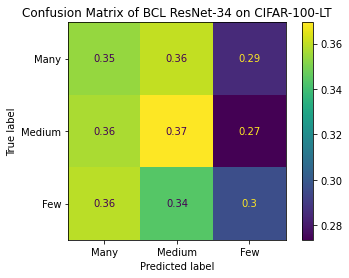

In [67]:
compute_class_acc(cls_num_list, temp_target, temp_pred, "BCL ResNet-34")